Le but de ce TP est de réaliser une classification supervisée des images du TP précédent. 4 approches peuvent être envisagées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée.
* Une approche par data generator, permettant facilement la data augmentation (les images sont alors directement récupérées à la volée dans le repertoire des images).
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation.
* Une approche par DataSet, avec data augmentation intégrée au modèle (layer en début de modèle).


<font color="orange">Préparer la cellule des imports.</font>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from plot_keras_history import show_history, plot_history
import seaborn as sns
from skimage import io
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


<font color="orange">Charger les fichiers pickle utilisés dans le TP précédent pour sérialiser nos variables utiles. Vérifier que les variables contiennent bien ce qu'on attend.</font>

In [2]:
with open("features_array.pkl", "rb") as handle:
    feat_pca_array = pkl.load(handle)
with open("img_df.pkl", "rb") as handle:
    img_df = pkl.load(handle)
print(feat_pca_array)
display(img_df.head())

[[ 1.9544766e+00 -1.4717954e+01 -5.3037477e+00 ... -7.2532974e-02
  -5.0635785e-01 -2.6224542e-01]
 [ 6.2963510e-01 -1.2585759e+01 -2.3373365e-01 ...  6.8578728e-02
   3.5400692e-01  1.1424346e-01]
 [-3.5353053e+00 -9.5045137e+00  1.0362120e+01 ... -2.8378537e-01
  -3.3193159e-01  2.7808327e-02]
 ...
 [ 3.2934761e+01  2.1253059e+01 -1.2920221e+01 ... -2.9714820e-01
  -2.1840538e-01 -4.5804556e-02]
 [ 3.4682747e+01  1.9640528e+01 -3.1260743e+00 ...  2.0042632e-03
   1.2696417e-01  1.4020243e-01]
 [ 2.1140398e+01  2.8663256e+00 -1.1699773e+01 ... -2.1752882e-01
   2.4104546e-01 -1.0651556e-01]]


,image_path,label_name,label
0,.\dataset\cloudy1.jpg,cloudy,0
1,.\dataset\cloudy10.jpg,cloudy,0
2,.\dataset\cloudy100.jpg,cloudy,0
3,.\dataset\cloudy101.jpg,cloudy,0
4,.\dataset\cloudy102.jpg,cloudy,0


<font color="orange">Redéclarer la liste des labels (dans l'ordre d'encodage avec le champ label).</font>

In [3]:
LABELS_LIST = ["cloudy", "rain", "shine", "sunrise"]

### Préparation des images

<font color="orange">En sélectionnant une image aléatoire du dataset, écrire le traitement que suivra cette image, en suivant les étapes suivantes :
- charger l'image avec la fonction load_img du module tensorflow.keras.preprocessing.image, en utilisant l'argument target_size pour forcer une redimension fixée à 224x224,
- convertir l'image en array avec la fonction img_to_array de ce même module,
- appliquer la fonction de préprocessing déjà prête de VGG16 : preprocess_input du module tensorflow.keras.applications.vgg16.

Ajouter une visualisation après l'étape 1 (pour se convaincre qu'on a bien chargé l'image initiale) ainsi qu'après l'étape 3 (pour visualiser que le préprocessing VGG16 déjà implémenté change significativement l'image, qui ne sera déjà plus vraiment interprétable à l'oeil).</font> Attention, petit rappel, après l'étape 1 l'objet est une image tandis qu'après la dernière étape il s'agit d'un array : les fonctions pour afficher ces deux objets ne sont donc pas tout à fait les mêmes.

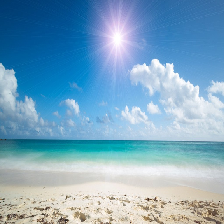

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


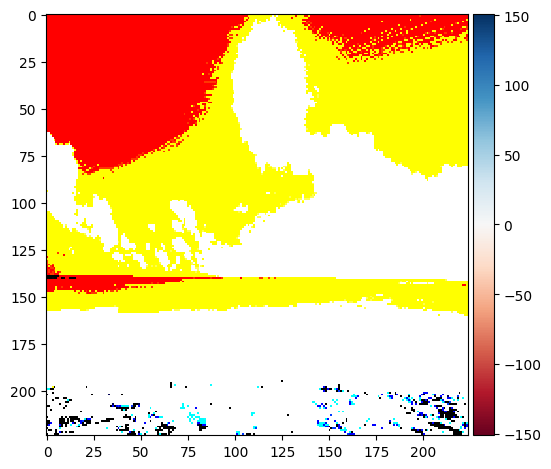

In [7]:
img = load_img(
    img_df['image_path'][765],
    target_size=(224, 224),
)
display(img)
img = img_to_array(img)
img = preprocess_input(img)
io.imshow(img)
io.show()

<font color="orange">A partir du traitement unitaire écrit précédemment, écrire la fonction prenant en entrée notre dataframe et créant le tableau de toutes les images contenues dans le dataframe (dans l'ordre).</font> Utiliser une simple boucle for pour créer une liste de représentations array d'images (ne pas réfléchir spécialement à des opérations vectorielles, le chargement même des images n'est pas vectorisable), puis convertir cette liste elle-même en tableau numpy grâce à np.array. Ne pas oublier d'enlever les visualisations, qui ne feraient que nous polluer désormais lorsque la fonction sera appelée sur le dataset entier de plus de 1000 images.

In [8]:
def prepare_image(image_path: str) -> np.array:
    """Extract features from an image given its path."""
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [24]:
X = img_df['image_path'].apply(prepare_image)
X = np.stack(X)
X = np.squeeze(X, axis=1)

In [25]:
X.shape

(1125, 224, 224, 3)

In [13]:
def prepare_images(img_df: pd.DataFrame) -> np.ndarray:
    prepared_images = []
    for image_num in range(len(img_df['image_path'])):
        img = (load_img(
            img_df['image_path'][image_num],
            target_size=(224, 224),
        ))
        img = img_to_array(img)
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [14]:
old_X = prepare_images(img_df=img_df)

In [27]:
print(old_X.shape)
X == old_X

(1125, 224, 224, 3)


array([[[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        ...,

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ T

<font color="orange">Appeler cette fonction sur notre dataframe d'images.</font> Ce traitement prendra plusieurs minutes.

<font color="orange">Préparer le vecteur y en appelant to_categorical sur la colonne contenant le label (numérique).</font>

In [28]:
y = to_categorical(img_df['label'])

<font color="orange">Séparer le jeu de données en un jeu d'entraînement et un jeu de test. Fixer un random_state pour garantir la reproductibilité des résultats pendant la phase d'élaboration de notre modèle. Stratifier selon la cible.</font>

In [29]:
X_macro_train, X_test, y_macro_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

Remarque : généralement cette étape est effectuée AVANT tout autre traitement afin d'éviter tout data leakage. Pour autant, ici, la fonction de préprocessing s'applique aux images de façon unitaire (le traitement d'un image n'est pas dépendant des autres images), et, étant donné la stratification, toutes les classes du référentiel seront nécessairement représentées dans le jeu d'entraînement et dans celui de test, de sorte que l'encoding de la cible dans le jeu de test ne révèlera pas de surprise de type modalité inconnue.

<font color="orange">Redécouper le jeu d'entraînement en mini-jeu d'entraînement et jeu de validation.</font>

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_macro_train, y_macro_train, stratify=y_macro_train, test_size=0.2, random_state=0)

In [31]:
X_train.shape

(720, 224, 224, 3)

### Préparation du modèle

<font color="orange">Ecrire une fonction permettant de créer notre modèle VGG16.</font> Pour cela :
- instancier un objet VGG16. A partir de la doc, faire en sorte d'initialiser les points à ceux du modèle pré-entraîné sur le jeu ImageNet. Choisir par exemple de ne pas inclure les 3 premières couches fully-connected, et spécifier dans ce cas une taille d'entrée de 224x224x3
- indiquer que toutes ces couches seront "gelées" (non entraînables). Pour cela, boucler sur l'ensemble des éléments de model.layers et définir l'attribut trainable à False.
- stocker dans une variable model.output, puis ajouter une couche de pooling, une couche dense, une couche de dropout et une dernière couche dense.
- définir le nouveau modèle et le compiler.

In [32]:
def create_model():
    """Create a model from the VGG16 model, adding a task head for image
    classification.
    """
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model


In [33]:
from tensorflow.keras.layers import Lambda
IMG_SIZE = 224

def create_model_fct2(num_categories):
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        #Rescaling(1./127.5, offset=-1.0)
    ])

    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

#     # Récupérer la sortie de ce réseau
#     x = model0.output
#     x = Lambda(resize_and_rescale, output_shape=(IMG_SIZE, IMG_SIZE, 3))(x)
#     x = data_augmentation(x)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(num_categories, activation='softmax')(x)

#     # Définir le nouveau modèle
#     model = Model(inputs=model0.input, outputs=predictions)
    
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model0,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(num_categories, activation='softmax')
                ])

    # compilation du modèle
    loss = "categorical_crossentropy"
    optimizer = 'adam'
    model_metrics = ["accuracy"]

    model.compile(loss=loss, optimizer=optimizer, metrics=model_metrics)

    print(model.summary())

    return model

<font color="orange">Créer effectivement le modèle, avec un context manager spécifiant le device à utiliser (c'est ici qu'on spécifierait quel GPU utiliser si on en disposer). Dans notre cas, utilisons "/cpu:0"</font>

In [34]:
with tf.device("/cpu:0"): 
    model1 = create_model_fct2(4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

<font color="orange">Créer un "callback" pour créer un early stopping de la manière suivante et sauvegarder le modèle de la manière suivante :</font>

In [35]:
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

<font color="orange">A l'intérieur du context manager spécifiant le device à utiliser, lancer l'entraînement du modèle. Prévoir dès maintenant de sauvegarder la sortie dans une variable appelée history (nous l'utiliserons plus tard). Attention à bien préciser le jeu de validation ! </font>

In [36]:
with tf.device('/cpu:0'): 
    history1 = model1.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1,
    )


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.3486 - accuracy: 0.3639
Epoch 1: val_loss improved from inf to 1.05983, saving model to .\model1_best_weights.h5


c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 146s 12s/step - loss: 1.3486 - accuracy: 0.3639 - val_loss: 1.0598 - val_accuracy: 0.6333
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.9783 - accuracy: 0.5917 
Epoch 2: val_loss improved from 1.05983 to 0.86639, saving model to .\model1_best_weights.h5
12/12 [==============================] - 156s 13s/step - loss: 0.9783 - accuracy: 0.5917 - val_loss: 0.8664 - val_accuracy: 0.7000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.7801 - accuracy: 0.7153 
Epoch 3: val_loss improved from 0.86639 to 0.70390, saving model to .\model1_best_weights.h5
12/12 [==============================] - 147s 12s/step - loss: 0.7801 - accuracy: 0.7153 - val_loss: 0.7039 - val_accuracy: 0.7944
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.7903 
Epoch 4: val_loss improved from 0.70390 to 0.61419, saving model to .\model1_best_weights.h5
12/12 [==============================] - 15

<font color="orange">Vérifier le score du dernier epoch sur le jeu d'entraînement et le jeu de validation grâce à la méthode evaluate de notre modèle entraîné.</font>

In [37]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))

23/23 [==============================] - 118s 5s/step - loss: 0.3111 - accuracy: 0.9056
Training Accuracy: 0.9056

6/6 [==============================] - 32s 5s/step - loss: 0.3561 - accuracy: 0.8944
Validation Accuracy: 0.8944


<font color="orange">Vérifier le score de l'epoch optimal sur le jeu de validation et le jeu de test.</font>

In [38]:
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8944
Test Accuracy       :  0.8578


<font color="orange">Consulter la doc de plot_keras_history. A partir de celle-ci, visualiser l'évolution de la loss et de l'accuracy au fil des epochs.</font>

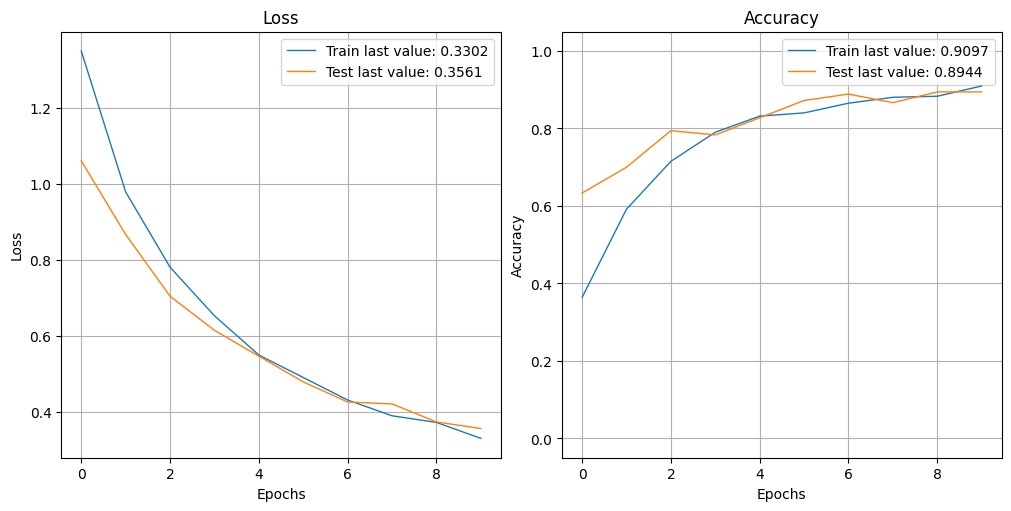

In [39]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

<font color="orange">Afficher les classes réelles et prédites sur les images du jeu de validation.</font>

In [40]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

print(y_val_num)
print(y_val_pred)

6/6 [==============================] - 33s 5s/step
[2 0 3 2 2 0 2 2 0 0 0 2 0 2 2 3 3 3 2 1 2 3 0 2 1 3 0 0 3 0 2 2 2 1 3 0 1
 1 0 0 1 3 2 0 3 3 1 1 0 3 2 3 3 0 1 0 2 3 1 0 0 3 3 3 1 3 3 0 3 1 3 1 2 2
 0 2 3 2 1 0 1 2 0 3 2 1 1 2 2 0 1 1 1 0 3 0 3 0 3 2 3 0 3 0 3 1 0 2 3 3 0
 2 3 0 3 3 0 2 3 3 1 1 1 2 3 3 0 0 3 3 0 1 3 0 2 2 3 2 1 2 1 1 3 0 3 0 0 0
 3 2 3 3 3 1 0 1 0 1 3 1 1 0 3 3 2 0 0 3 0 2 3 3 2 1 2 2 0 3 3 2]
[2 0 3 3 2 0 2 2 2 0 2 2 0 2 2 3 3 3 3 1 2 3 0 2 1 3 0 0 3 0 2 3 2 1 3 0 1
 1 0 0 1 3 2 0 3 3 1 1 0 3 2 3 3 2 1 0 2 3 1 0 0 3 3 3 1 3 3 0 3 1 3 1 2 2
 0 2 3 3 1 2 1 2 0 3 2 1 1 2 2 3 1 1 1 0 3 0 3 0 3 2 3 0 3 0 3 1 0 2 3 3 0
 3 3 0 3 3 0 2 3 2 1 1 1 3 3 3 0 0 3 3 0 1 2 0 3 2 3 2 1 2 1 1 3 0 3 0 0 0
 3 2 3 3 3 1 3 1 0 1 3 1 1 1 3 3 2 0 3 3 2 3 3 3 2 1 2 2 0 3 3 2]


<font color="orange">De manière analogue au TP précédent, afficher la matrice de confusion associée ainsi que le rapport de classification.</font>

In [41]:
conf_mat = metrics.confusion_matrix(
    y_true=y_val_num,
    y_pred=y_val_pred,
)
print(conf_mat)

[[39  1  5  3]
 [ 0 34  0  0]
 [ 0  0 33  8]
 [ 0  0  2 55]]


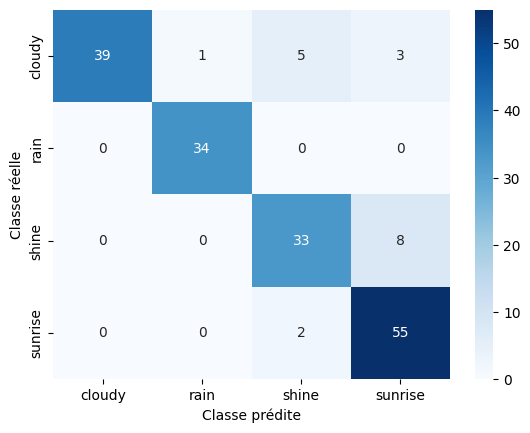

In [42]:
sns.heatmap(
    data=conf_mat,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [43]:
print(metrics.classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        48
           1       0.97      1.00      0.99        34
           2       0.82      0.80      0.81        41
           3       0.83      0.96      0.89        57

    accuracy                           0.89       180
   macro avg       0.91      0.90      0.90       180
weighted avg       0.90      0.89      0.89       180



<font color="orange">Essayer éventuellement de visualiser les prédictions sur les images de test. <br> Il serait en particulier intéressant de voir la prédiction du modèle sur des images présentant des écueils soulevés dans le TP précédent (par exemple des images avec de la neige) qui n'auraient pas été utilisées dans le jeu d'entraînement, s'il y en a.</font>

In [44]:
def predict(paths):
    import os
    img_df = pd.DataFrame(
        {
            "image_path": [
                os.path.join(os.getcwd(), path)
                for path in paths
            ]
        }
    )
    X = prepare_images(img_df=img_df)
    y_class_pred = np.argmax(model1.predict(X), axis=1)
    y_class_pred = np.array([LABELS_LIST[i] for i in y_class_pred])
    return y_class_pred


In [45]:
predict([
    "test_image_rain.jpg",
    "test_image_sunrise.jpg",
])

1/1 [==============================] - 1s 665ms/step


array(['rain', 'sunrise'], dtype='<U7')

### Data augmentation (intégrée au modèle)

Une ressource utile est celle de tensorflow sur la data augmentation, située à l'adresse suivante : https://www.tensorflow.org/tutorials/images/data_augmentation

Grâce au tutorial (première méthode), créer une data augmentation contenant RandomFlip, RandomRotation et RandomZoom.

In [26]:
def create_model_with_data_augmentation() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
      data_augmentation,
      Rescaling(1./127.5, offset=-1),
      model_base,
      GlobalAveragePooling2D(),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(4, activation='softmax')
    ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [27]:
# Création du modèle
with tf.device('/cpu:0'): 
    model4 = create_model_with_data_augmentation()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [28]:
with tf.device('/cpu:0'): 
    history4 = model4.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1,
    )

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.3558 - accuracy: 0.3639 
Epoch 1: val_loss improved from inf to 1.04060, saving model to .\model4_best_weights.h5
12/12 [==============================] - 151s 12s/step - loss: 1.3558 - accuracy: 0.3639 - val_loss: 1.0406 - val_accuracy: 0.5556
Epoch 2/10


c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - ETA: 0s - loss: 0.9434 - accuracy: 0.6653 
Epoch 2: val_loss improved from 1.04060 to 0.81048, saving model to .\model4_best_weights.h5
12/12 [==============================] - 146s 12s/step - loss: 0.9434 - accuracy: 0.6653 - val_loss: 0.8105 - val_accuracy: 0.8000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.7583 
Epoch 3: val_loss improved from 0.81048 to 0.67393, saving model to .\model4_best_weights.h5
12/12 [==============================] - 164s 14s/step - loss: 0.7481 - accuracy: 0.7583 - val_loss: 0.6739 - val_accuracy: 0.8000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.8153 
Epoch 4: val_loss improved from 0.67393 to 0.60083, saving model to .\model4_best_weights.h5
12/12 [==============================] - 151s 13s/step - loss: 0.6149 - accuracy: 0.8153 - val_loss: 0.6008 - val_accuracy: 0.8000
Epoch 5/10
12/12 [==============================] - ET

<font color="orange">Reprendre l'ensemble des questions précédentes et comparer les deux modèles.</font>

In [49]:
X.shape

(1125, 224, 224, 3)

In [51]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Path to images and label list
IMG_FOLDER = os.getenv("IMG_FOLDER")
LABELS_LIST = ["cloudy", "rain", "shine", "sunrise"]

# Helper functions
def get_image_label(img_filename: str, possible_labels=None, label_not_found_value="unknown") -> str:
    """Extract label from the image file name."""
    if possible_labels is None:
        possible_labels = LABELS_LIST
    for label in possible_labels:
        if label in img_filename:
            return label
    return label_not_found_value

def create_data_from_img_files(path: str = IMG_FOLDER) -> pd.DataFrame:
    """Create DataFrame with image paths and labels."""
    images_list = glob(f"{path}*/*.jp*")
    df_out = pd.DataFrame(data={"image_path": images_list})
    df_out["label_name"] = df_out["image_path"].apply(get_image_label)
    return df_out

# Custom Dataset for loading images
class ImageDataset(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform
        self.label_mapping = {label: i for i, label in enumerate(LABELS_LIST)}

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df.iloc[idx]["image_path"]
        label = self.img_df.iloc[idx]["label_name"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.label_mapping[label]
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create DataFrame and split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)


# Create datasets and dataloaders
train_dataset = ImageDataset(X_train, transform=transform)
val_dataset = ImageDataset(X_val, transform=transform)
test_dataset = val_dataset  # to be improved

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Lightning Model Definition
class VGG16Lightning(pl.LightningModule):
    def __init__(self, num_classes=4):
        super(VGG16Lightning, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze pretrained layers
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)  # Modify the last layer
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = Accuracy()
        self.val_acc = Accuracy()
    
    def forward(self, x):
        return self.vgg(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.vgg.classifier[6].parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.train_acc(outputs, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.val_acc(outputs, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.val_acc(outputs, labels)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

# Model creation
model = VGG16Lightning(num_classes=4)

# Callbacks for checkpoint and early stopping
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Training
trainer.fit(model, train_loader, val_loader)

# Testing
trainer.test(model, test_loader)

# Confusion matrix and classification report
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Matrice de confusion et rapport de classification
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=LABELS_LIST))


c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'